<a href="https://colab.research.google.com/github/brKhoo/GarbageBot/blob/main/warehouse_location_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Available columns in df_transposed: ['Neighbourhood Number', 'Population 15 to 64 years', 'Median total income', 'Transportation Services', 'Amazon Purchase & Return Density', 'Land Availability & Cost']

Missing values after initial load:   Neighbourhood Name
Neighbourhood Number         0
population_15_64             0
median_total_income          0
transportation_services      0
purchase_density             0
land_availability_cost     158
dtype: int64
⚠️ Warning: All values in land_availability_cost are missing! Assigning a default value.

Missing values after after filling NaNs:   Neighbourhood Name
Neighbourhood Number       0
population_15_64           0
median_total_income        0
transportation_services    0
purchase_density           0
land_availability_cost     0
dtype: int64
Number of valid rows after cleaning: 158
Top 5 Warehouse Locations (Low Cost & High Availability Focus):

Rank: 1
Neighbourhood: St Lawrence-East Bayfront-The Islands
  Neighbourhood Name
population_15

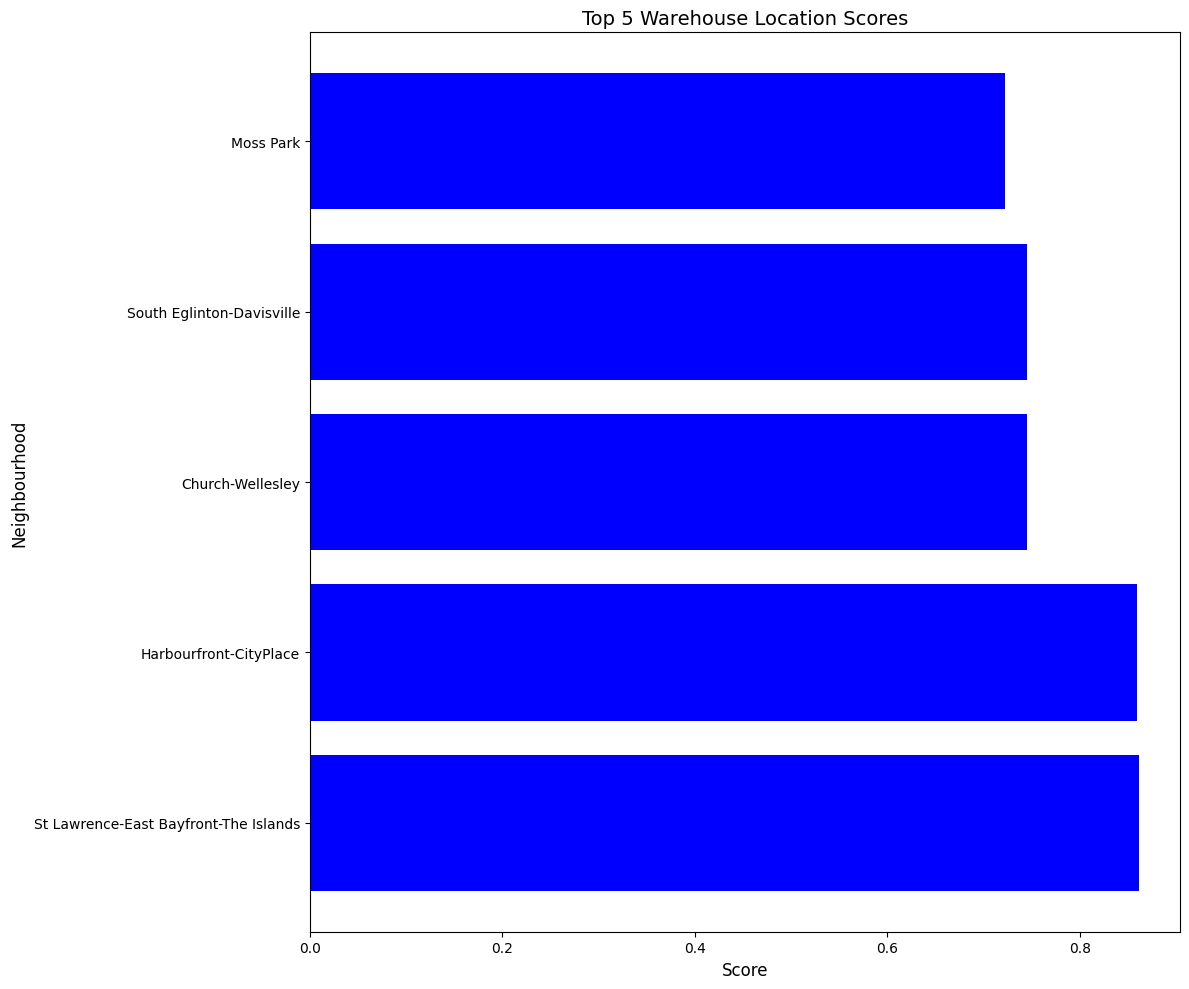

In [ ]:
!pip install openpyxl matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load synthetic data from the provided Excel file
file_path = "/content/neighbourhood-profiles-2021-158-model.xlsx"

# Load the relevant sheet
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='hd2021_census_profile')

# Transpose the dataset to make neighbourhoods rows instead of columns
df_transposed = df.set_index(df.columns[0]).transpose()
df_transposed.reset_index(inplace=True)

# added to set the index
df_transposed = df_transposed.rename(columns={'index': 'Neighbourhood Name'})
df_transposed.set_index("Neighbourhood Name", inplace=True)

# ✅ Strip spaces from column names (Fixes KeyError)
df_transposed.columns = df_transposed.columns.str.strip()

# ✅ Print available columns for debugging
print("Available columns in df_transposed:", df_transposed.columns.tolist())

# ✅ Rename relevant columns
df_transposed.rename(columns={
    "Population 15 to 64 years": "population_15_64",
    "Median total income": "median_total_income",
    "Transportation Services": "transportation_services",
    "Amazon Purchase & Return Density": "purchase_density",
    "Land Availability & Cost": "land_availability_cost"
}, inplace=True)

# Convert numerical columns to appropriate types
df_transposed["population_15_64"] = pd.to_numeric(df_transposed["population_15_64"], errors='coerce')
df_transposed["median_total_income"] = pd.to_numeric(df_transposed["median_total_income"], errors='coerce')
df_transposed["transportation_services"] = pd.to_numeric(df_transposed["transportation_services"], errors='coerce')
df_transposed["land_availability_cost"] = pd.to_numeric(df_transposed["land_availability_cost"], errors='coerce')

# Define mapping for purchase density categories
density_mapping = {
    "Very Low": 0.1,
    "Low": 0.3,
    "Medium": 0.5,
    "High": 0.7,
    "Very High": 1.0,
    None: 0.0  # Added to address NaN values due to missing values or mapping issues.
}
df_transposed["purchase_density"] = df_transposed["purchase_density"].map(density_mapping).fillna(0)  # Fill any new NaN values created by unknown categories with 0

# Debug: Print missing values before handling
def print_missing_values(df, step):
    print(f"\nMissing values after {step}:", df.isnull().sum())

print_missing_values(df_transposed, "initial load")

# ✅ Fill missing values with median before dropping anything
for col in ["population_15_64", "median_total_income", "transportation_services", "purchase_density"]:
    if df_transposed[col].isnull().all():
        print(f"⚠️ Warning: Column {col} has all missing values! Consider fixing the dataset.")
    else:
        df_transposed[col] = df_transposed[col].fillna(df_transposed[col].median())  # changed to direct assignment

# ✅ Special handling for land_availability_cost
if df_transposed["land_availability_cost"].isnull().all():
    print("⚠️ Warning: All values in land_availability_cost are missing! Assigning a default value.")
    df_transposed["land_availability_cost"] = df_transposed["land_availability_cost"].fillna(0.5)  # Assign a neutral default value  # changed to direct assignment
else:
    df_transposed["land_availability_cost"] = df_transposed["land_availability_cost"].fillna(df_transposed["land_availability_cost"].median())  # changed to direct assignment

print_missing_values(df_transposed, "after filling NaNs")

# ✅ Drop rows only if absolutely necessary
df_transposed.dropna(subset=["purchase_density"], inplace=True)

# ✅ Print number of valid rows remaining
print(f"Number of valid rows after cleaning: {len(df_transposed)}")
if df_transposed.empty:
    print("No valid data available for scoring.")
    exit()

# ✅ Ensure no column is entirely NaN before normalizing
norm_columns = ["median_total_income", "population_15_64", "transportation_services", "purchase_density", "land_availability_cost"]
valid_norm_columns = [col for col in norm_columns if not df_transposed[col].isnull().all()]
if not valid_norm_columns:
    print("No valid columns available for normalization.")
    exit()

# Normalize the parameters for fair comparison
scaler = MinMaxScaler()
df_transposed[valid_norm_columns] = scaler.fit_transform(df_transposed[valid_norm_columns])

# Define weightings for low cost & high availability focus
weights = {
    'median_total_income': 0.20,  # Lower importance
    'population_15_64': 0.15,     # Workforce availability remains highly important
    'transportation_services': 0.10,  # Moderate importance
    'purchase_density': 0.50,  # Less influence
    'land_availability_cost': 0.40  # Highest importance (low cost, high availability)
}

# Compute a weighted score for each location
df_transposed['score'] = sum(df_transposed[col] * weights[col] for col in valid_norm_columns if col in weights)

# Sort the DataFrame by score in descending order
df_sorted = df_transposed.sort_values(by='score', ascending=False)

# Print the top 5 warehouse locations
print("Top 5 Warehouse Locations (Low Cost & High Availability Focus):")
for i in range(min(5, len(df_sorted))):  # Ensure we don't exceed the number of available locations
    location_name = df_sorted.index[i]
    location = df_sorted.loc[location_name]
    print(f"\nRank: {i+1}")
    print(f"Neighbourhood: {location_name}")
    print(location[["population_15_64", "median_total_income", "transportation_services", "purchase_density", "land_availability_cost", "score"]])

# Visualizing top warehouse location scores
plt.figure(figsize=(12, 10))  # Adjusted figure size for better visualization
plt.barh(df_sorted.index[:min(5, len(df_sorted))], df_sorted['score'][:min(5, len(df_sorted))], color='blue') #reduced scope of index
plt.xlabel('Score', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12) # Changed y-axis label
plt.yticks(fontsize=10)  # Adjusted fontsize

plt.title('Top 5 Warehouse Location Scores', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()